In [1]:

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from darts.models import BlockRNNModel

/Users/DocWeaver/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/DocWeaver/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/DocWeaver/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/DocWeaver/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
df = pd.read_csv("../data/historic_demand_2009_2023.csv")

In [4]:
elec_df = df[192_816: 194_788]

In [5]:
elec_df = elec_df[["settlement_date", "embedded_wind_generation"]]

In [6]:
elec_df.head()

,settlement_date,embedded_wind_generation
192816,2020-01-01,1244
192817,2020-01-01,1188
192818,2020-01-01,1156
192819,2020-01-01,1125
192820,2020-01-01,1106


In [7]:
wind_df = pd.read_csv("../data/Hull_2020-01-01_to_2020-02-10.csv")
wind_df["windgust"].tail()


979    53.6
980    49.7
981    57.8
982    65.0
983    78.4
Name: windgust, dtype: float64

In [8]:
wind_df = wind_df[["datetime","windgust", "windspeed"]]

In [9]:
wind_df['windgust'] = wind_df['windgust'].fillna(0)

In [10]:
wind_df.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,1.7
1,2020-01-01T01:00:00,0.0,4.1
2,2020-01-01T02:00:00,0.0,4.0
3,2020-01-01T03:00:00,0.0,4.3
4,2020-01-01T04:00:00,0.0,4.3


In [11]:
wind_df_long = pd.DataFrame(np.repeat(wind_df.values, 2, axis=0))
wind_df_long.columns = wind_df.columns
wind_df_long.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,1.7
1,2020-01-01T00:00:00,0.0,1.7
2,2020-01-01T01:00:00,0.0,4.1
3,2020-01-01T01:00:00,0.0,4.1
4,2020-01-01T02:00:00,0.0,4.0


In [12]:
wind_df_long["windspeed"] = wind_df_long["windspeed"]*120

In [13]:
wind_df_long.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,204.0
1,2020-01-01T00:00:00,0.0,204.0
2,2020-01-01T01:00:00,0.0,492.0
3,2020-01-01T01:00:00,0.0,492.0
4,2020-01-01T02:00:00,0.0,480.0


In [14]:
test_begin_point = 1475

In [15]:
endog_train = elec_df["embedded_wind_generation"][:test_begin_point].to_numpy()
endog_train = np.array(endog_train, dtype=float)
len(endog_train)

1475

In [16]:
endog_test_df = elec_df["embedded_wind_generation"][test_begin_point:-4]
endog_test = np.array(endog_test_df, dtype=float)
len(endog_test)

493

In [17]:
exog_train = wind_df_long["windspeed"][:test_begin_point].to_numpy()
exog_train = np.array(exog_train, dtype=float)
exog_train = exog_train
len(exog_train)

1475

In [18]:
exog_test = wind_df_long["windspeed"][test_begin_point:].to_numpy()
exog_test = np.array(exog_test, dtype=float)
exog_test = exog_test
len(exog_test)

493

In [19]:
wind_df_long["datetime"]

0       2020-01-01T00:00:00
1       2020-01-01T00:00:00
2       2020-01-01T01:00:00
3       2020-01-01T01:00:00
4       2020-01-01T02:00:00
               ...         
1963    2020-02-10T21:00:00
1964    2020-02-10T22:00:00
1965    2020-02-10T22:00:00
1966    2020-02-10T23:00:00
1967    2020-02-10T23:00:00
Name: datetime, Length: 1968, dtype: object

In [20]:
endog_train = pd.DataFrame(endog_train.astype(float),columns=["endog"])

In [21]:
exog_train= pd.DataFrame(exog_train.astype(float),columns=["exog"])

In [22]:
datetime_series = pd.to_datetime(wind_df_long["datetime"][:test_begin_point], format = '%Y-%m-%dT%H:%M:%S')

In [23]:
import datetime

In [24]:
date_and_time = datetime_series[1]
date_and_time

Timestamp('2020-01-01 00:00:00')

In [25]:
def thirty_min_adder(date_and_time):
    time_change = datetime.timedelta(minutes=30)
    new_time = date_and_time + time_change
    return new_time

In [26]:
new_date_and_time = (thirty_min_adder(date_and_time))
new_date_and_time

Timestamp('2020-01-01 00:30:00')

In [27]:
datetime_series_odd = datetime_series.iloc[1::2].apply(thirty_min_adder)

In [28]:
datetime_series_odd

1      2020-01-01 00:30:00
3      2020-01-01 01:30:00
5      2020-01-01 02:30:00
7      2020-01-01 03:30:00
9      2020-01-01 04:30:00
               ...        
1465   2020-01-31 12:30:00
1467   2020-01-31 13:30:00
1469   2020-01-31 14:30:00
1471   2020-01-31 15:30:00
1473   2020-01-31 16:30:00
Name: datetime, Length: 737, dtype: datetime64[ns]

In [29]:
datetime_series.update(datetime_series_odd)

In [30]:
datetime_series

0      2020-01-01 00:00:00
1      2020-01-01 00:30:00
2      2020-01-01 01:00:00
3      2020-01-01 01:30:00
4      2020-01-01 02:00:00
               ...        
1470   2020-01-31 15:00:00
1471   2020-01-31 15:30:00
1472   2020-01-31 16:00:00
1473   2020-01-31 16:30:00
1474   2020-01-31 17:00:00
Name: datetime, Length: 1475, dtype: datetime64[ns]

In [31]:
data = pd.concat([datetime_series,endog_train, exog_train], axis=1)
data.set_index(["datetime"], inplace = True)
data.head()

,endog,exog
datetime,,
2020-01-01 00:00:00,1244.0,204.0
2020-01-01 00:30:00,1188.0,204.0
2020-01-01 01:00:00,1156.0,492.0
2020-01-01 01:30:00,1125.0,492.0
2020-01-01 02:00:00,1106.0,480.0


In [32]:
endog_timeseries = TimeSeries.from_series(data["endog"])
exog_timeseries = TimeSeries.from_series(data["exog"])

In [33]:
endog_timeseries

<TimeSeries (DataArray) (datetime: 1475, component: 1, sample: 1)>
array([[[1244.]],

       [[1188.]],

       [[1156.]],

       ...,

       [[3961.]],

       [[3957.]],

       [[3946.]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2020-01-01 ... 2020-01-31T17:00:00
  * component  (component) object 'endog'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

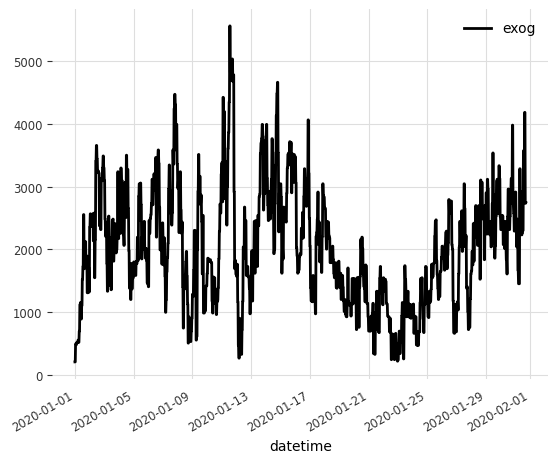

In [34]:
exog_timeseries.plot()

In [35]:
endog_train, _ = endog_timeseries.split_before(0.8)

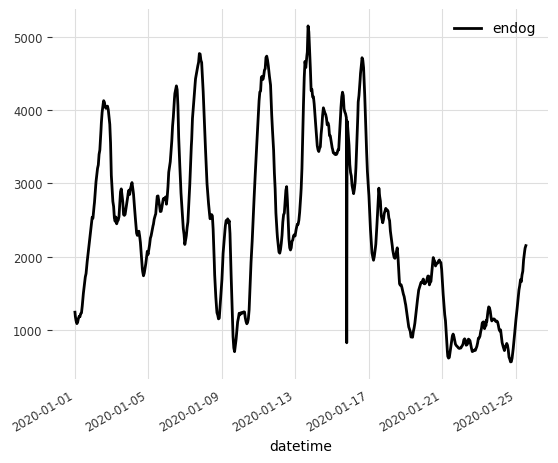

In [36]:
endog_train.plot()

In [37]:
from darts.metrics import rmse


In [38]:
def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=endog, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(endog, backtest)))

In [ ]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)
brnn_no_cov.to_cpu()
brnn_no_cov.fit(endog_train, 
                epochs=1, 
                verbose=True)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
eval_model(brnn_no_cov)

In [ ]:
print(mod.summary())

In [ ]:
# Forecast
forecast_length = 100
results = mod.get_forecast(forecast_length, exog = exog_test[:forecast_length], alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
forecast

In [ ]:
def plot_forecast(fc, train, test, windspeed, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    wind_series = pd.Series(windspeed)
    wind_series = wind_series
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training generation', color='black')
    plt.plot(test, label='actual generation', color='black', ls='--')
    plt.plot(fc_series, label='forecast generation', color='orange')
    plt.plot(wind_series, label='wind speed in hull', color='blue')
    plt.xlim(test_begin_point-200,test_begin_point+200)
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [ ]:
endog_test = pd.DataFrame(endog_test)
endog_test.index = endog_test.index + test_begin_point

In [ ]:
forecast_recons = pd.Series(forecast, index=endog_test.index[:forecast_length])

plot_forecast(forecast_recons,endog_train, endog_test, wind_df_long["windspeed"])